# CenterNet with Test Time Augumentation
![](https://camo.githubusercontent.com/817c7a27705ee1ac0bbd6f5ebc4982f224d7a0b3/68747470733a2f2f707265766965772e6962622e636f2f6b48363176302f706970656c696e652e706e67)
https://github.com/andrewekhalel/edafa

What is Test time augumentation (TTA)?

Applying different transformations to test images and averaging will **improve accuracy.**

Resnet18 CenterNet

without TTA:
LB 0.44

**With TTA:
LB 0.52 **

mAP increases 8%! Wow!!

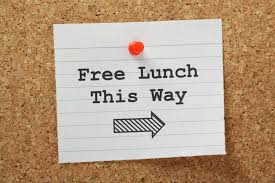

Here, we use the segmentation wrapper of TTACH to implement TTA.

## Training of centernet
https://www.kaggle.com/kyoshioka47/centernet-starterkit-pytorch?rvi=1

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

In [ ]:
!pip install ../input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4/ > /dev/null # no output

Install TTACH for easy TTA

In [ ]:
!pip install ../input/ttach-kaggle/ttach/ > /dev/null # no output
import ttach as tta

In [ ]:
input_size = 512
IN_SCALE = 1024//input_size
MODEL_SCALE = 4
batch_size = 4
model_name = "resnet18"
TRAIN = False

## Prepare labels

In [ ]:
DIR_INPUT = '../input/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.shape

In [ ]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

In [ ]:
# Split train-test
from sklearn.model_selection import train_test_split
# Split by unique image ids.
image_ids = train_df['image_id'].unique()
train_id, test_id = train_test_split(image_ids, test_size=0.2, random_state=777)

## convert boxes to heatmap

In [ ]:
# Make heatmaps using the utility functions from the centernet repo
def draw_msra_gaussian(heatmap, center, sigma=2):
  tmp_size = sigma * 6
  mu_x = int(center[0] + 0.5)
  mu_y = int(center[1] + 0.5)
  w, h = heatmap.shape[0], heatmap.shape[1]
  ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
  br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
  if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
    return heatmap
  size = 2 * tmp_size + 1
  x = np.arange(0, size, 1, np.float32)
  y = x[:, np.newaxis]
  x0 = y0 = size // 2
  g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
  g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
  g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
  img_x = max(0, ul[0]), min(br[0], h)
  img_y = max(0, ul[1]), min(br[1], w)
  heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
    g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
  return heatmap
def draw_dense_reg(regmap, heatmap, center, value, radius, is_offset=False):
  diameter = 2 * radius + 1
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
  value = np.array(value, dtype=np.float32).reshape(-1, 1, 1)
  dim = value.shape[0]
  reg = np.ones((dim, diameter*2+1, diameter*2+1), dtype=np.float32) * value
  if is_offset and dim == 2:
    delta = np.arange(diameter*2+1) - radius
    reg[0] = reg[0] - delta.reshape(1, -1)
    reg[1] = reg[1] - delta.reshape(-1, 1)
  
  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]
    
  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
  masked_regmap = regmap[:, y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom,
                             radius - left:radius + right]
  masked_reg = reg[:, radius - top:radius + bottom,
                      radius - left:radius + right]
  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
    idx = (masked_gaussian >= masked_heatmap).reshape(
      1, masked_gaussian.shape[0], masked_gaussian.shape[1])
    masked_regmap = (1-idx) * masked_regmap + idx * masked_reg
  regmap[:, y - top:y + bottom, x - left:x + right] = masked_regmap
  return regmap

def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

In [ ]:
# Wrapped heatmap function
def make_hm_regr(target):
    # make output heatmap for single class
    hm = np.zeros([input_size//MODEL_SCALE, input_size//MODEL_SCALE])
    # make regr heatmap 
    regr = np.zeros([2, input_size//MODEL_SCALE, input_size//MODEL_SCALE])
    
    if len(target) == 0:
        return hm, regr
    
    try:
        center = np.array([target["x"]+target["w"]//2, target["y"]+target["h"]//2, 
                       target["w"], target["h"]
                      ]).T
    except:
        center = np.array([int(target["x"]+target["w"]//2), int(target["y"]+target["h"]//2), 
                       int(target["w"]), int(target["h"])
                      ]).T.reshape(1,4)
    
    # make a center point
    # try gaussian points.
    for c in center:
        hm = draw_msra_gaussian(hm, [int(c[0])//MODEL_SCALE//IN_SCALE, int(c[1])//MODEL_SCALE//IN_SCALE], 
                                sigma=np.clip(c[2]*c[3]//2000, 2, 4))    

    # convert targets to its center.
    regrs = center[:, 2:]/input_size/IN_SCALE

    # plot regr values to mask
    for r, c in zip(regrs, center):
        for i in range(-2, 3):
            for j in range(-2, 3):
                try:
                    regr[:, int(c[0])//MODEL_SCALE//IN_SCALE+i, 
                         int(c[1])//MODEL_SCALE//IN_SCALE+j] = r
                except:
                    pass
    regr[0] = regr[0].T; regr[1] = regr[1].T;
    return hm, regr

In [ ]:
def pred2box(hm, regr, thresh=0.99):
    # make binding box from heatmaps
    # thresh: threshold for logits.
        
    # get center
    pred = hm > thresh
    pred_center = np.where(hm>thresh)
    # get regressions
    pred_r = regr[:,pred].T

    # wrap as boxes
    # [xmin, ymin, width, height]
    # size as original image.
    boxes = []
    scores = hm[pred]
    for i, b in enumerate(pred_r):
        arr = np.array([pred_center[1][i]*MODEL_SCALE-b[0]*input_size//2, pred_center[0][i]*MODEL_SCALE-b[1]*input_size//2, 
                      int(b[0]*input_size), int(b[1]*input_size)])
        arr = np.clip(arr, 0, 1024)
        # filter 
        #if arr[0]<0 or arr[1]<0 or arr[0]>input_size or arr[1]>input_size:
            #pass
        boxes.append(arr)
    return np.asarray(boxes), scores

In [ ]:
# functions for plotting results
def showbox(img, hm, regr, thresh=0.9):
    boxes, _ = pred2box(hm, regr, thresh=thresh)
    print("preds:",boxes.shape)
    sample = img

    for box in boxes:
        # upper-left, lower-right
        cv2.rectangle(sample,
                      (int(box[0]), int(box[1]+box[3])),
                      (int(box[0]+box[2]), int(box[1])),
                      (220, 0, 0), 3)
    return sample

def showgtbox(img, hm, regr, thresh=0.9):
    boxes, _ = pred2box(hm, regr, thresh=thresh)
    print("GT boxes:", boxes.shape)
    sample = img

    for box in boxes:
        cv2.rectangle(sample,
                      (int(box[0]), int(box[1]+box[3])),
                      (int(box[0]+box[2]), int(box[1])),
                      (0, 220, 0), 3)
    return sample

## make dataset

In [ ]:
from torchvision import transforms

class Normalize(object):
    def __init__(self):
        self.mean=[0.485, 0.456, 0.406]
        self.std=[0.229, 0.224, 0.225]
        self.norm = transforms.Normalize(self.mean, self.std)
    def __call__(self, image):
        image = image.astype(np.float32)/255
        axis = (0,1)
        image -= self.mean
        image /= self.std
        return image
    
# pool duplicates
def pool(data):
    stride = 3
    for y in np.arange(1,data.shape[1]-1, stride):
        for x in np.arange(1, data.shape[0]-1, stride):
            a_2d = data[x-1:x+2, y-1:y+2]
            max = np.asarray(np.unravel_index(np.argmax(a_2d), a_2d.shape))            
            for c1 in range(3):
                for c2 in range(3):
                    #print(c1,c2)
                    if not (c1== max[0] and c2 == max[1]):
                        data[x+c1-1, y+c2-1] = -1
    return data

# NMS is required to remove duplicate boxes
def nms(boxes, scores, overlap=0.45, top_k=200):
    scores = torch.from_numpy(scores)
    
    count = 0
    keep = scores.new(scores.size(0)).zero_().long()
    boxes = boxes.reshape(-1, 4)
    boxes = torch.from_numpy(np.array([boxes[:,0], boxes[:,1], boxes[:,0]+boxes[:,2], boxes[:,1]+boxes[:,3]]).T.reshape(-1, 4))
    
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)

    tmp_x1 = boxes.new()
    tmp_y1 = boxes.new()
    tmp_x2 = boxes.new()
    tmp_y2 = boxes.new()
    tmp_w = boxes.new()
    tmp_h = boxes.new()

    v, idx = scores.sort(0)

    idx = idx[-top_k:]

    while idx.numel() > 0:
        i = idx[-1]  
        keep[count] = i
        count += 1


        if idx.size(0) == 1:
            break

        idx = idx[:-1]

        torch.index_select(x1, 0, idx, out=tmp_x1)
        torch.index_select(y1, 0, idx, out=tmp_y1)
        torch.index_select(x2, 0, idx, out=tmp_x2)
        torch.index_select(y2, 0, idx, out=tmp_y2)


        tmp_x1 = torch.clamp(tmp_x1, min=x1[i])
        tmp_y1 = torch.clamp(tmp_y1, min=y1[i])
        tmp_x2 = torch.clamp(tmp_x2, max=x2[i])
        tmp_y2 = torch.clamp(tmp_y2, max=y2[i])

        tmp_w.resize_as_(tmp_x2)
        tmp_h.resize_as_(tmp_y2)

        tmp_w = tmp_x2 - tmp_x1
        tmp_h = tmp_y2 - tmp_y1

        tmp_w = torch.clamp(tmp_w, min=0.0)
        tmp_h = torch.clamp(tmp_h, min=0.0)

        inter = tmp_w*tmp_h

        rem_areas = torch.index_select(area, 0, idx)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union


        idx = idx[IoU.le(overlap)]  

    return keep.numpy(), count

class WheatDataset(torch.utils.data.Dataset):
    def __init__(self, img_id, labels, transform=None):
        self.img_id = img_id
        self.labels = labels
        if transform:
            self.transform = transform
        self.normalize = Normalize()
        
    def __len__(self):
        return len(self.img_id)

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(DIR_INPUT,"train", self.img_id[idx]+".jpg"))
        img = cv2.resize(img, (input_size, input_size))
        img = self.normalize(img)
        img = img.transpose([2,0,1])
        target = self.labels[self.labels['image_id']==self.img_id[idx]]
        hm, regr = make_hm_regr(target)
        return img, hm, regr
    
class WheatDatasetTest(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.img_id = os.listdir(self.image_dir)
        if transform:
            self.transform = transform
        self.normalize = Normalize()
        
    def __len__(self):
        return len(self.img_id)

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(self.image_dir, self.img_id[idx]))
        img = cv2.resize(img, (input_size, input_size))
        img = self.normalize(img)
        img = img.transpose([2,0,1])
        return img, self.img_id[idx]

In [ ]:
traindataset = WheatDataset(train_id, train_df)
valdataset = WheatDataset(test_id, train_df)
testdataset = WheatDatasetTest('../input/global-wheat-detection/test')

In [ ]:
train_loader = torch.utils.data.DataLoader(traindataset,batch_size=batch_size,shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(valdataset,batch_size=batch_size,shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(testdataset,batch_size=batch_size,shuffle=False, num_workers=0)

## Define CenterNet

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
import pretrainedmodels

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch)
        
    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
            # input is CHW
            diffY = x2.size()[2] - x1.size()[2]
            diffX = x2.size()[3] - x1.size()[3]

            x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                            diffY // 2, diffY - diffY//2))
        else:
            x = x1
        x = self.conv(x)
        return x

class centernet(nn.Module):
    def __init__(self, n_classes=1, model_name="resnet18"):
        super(centernet, self).__init__()
        # create backbone.
        basemodel = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained=None)
        basemodel = nn.Sequential(*list(basemodel.children())[:-2])
        # set basemodel
        self.base_model = basemodel
        
        if model_name == "resnet34" or model_name=="resnet18":
            num_ch = 512
        else:
            num_ch = 2048
        
        self.up1 = up(num_ch, 512)
        self.up2 = up(512, 256)
        self.up3 = up(256, 256)
        # output classification
        self.outc = nn.Conv2d(256, n_classes, 1)
        # output residue
        self.outr = nn.Conv2d(256, 2, 1)
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = self.base_model(x)
        
        # Add positional info        
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        outc = self.outc(x)
        outr = self.outr(x)
        return outc, outr

In [ ]:
# Define model
model = centernet()
model(torch.rand(1,3,512,512))[0].size()

In [ ]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Load model weights

In [ ]:
import gc
model.load_state_dict(torch.load('../input/trained-centernet/{}_{}epochs_saved_weights.pth'.format(model_name, 70)))

# Make TTA wrapper

In [ ]:
import torch.nn as nn
# wrap model so that it outputs a single output
class model2(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        hm, regr = self.model(x)
        return torch.cat((hm, regr), axis=1)

# we define 24 augmentations here.
transforms = tta.Compose(
    [
        tta.HorizontalFlip(),
        tta.VerticalFlip(),
        tta.Rotate90(angles=[0, 180]),
        tta.Multiply(factors=[0.9, 1, 1.1]),        
    ]
)

# Define TTA model
model3 = model2(model)
tta_model = tta.SegmentationTTAWrapper(model3, transforms)

Test inference

In [ ]:
for id in range(10):
    img, hm_gt, regr_gt = valdataset[id]
    img = torch.from_numpy(img)
    with torch.no_grad():
        out = tta_model(img.to(device).float().unsqueeze(0))
        hm = out[:,0:1]
        regr = out[:,1:]

    
    hm = hm.cpu().numpy().squeeze(0).squeeze(0)
    regr = regr.cpu().numpy().squeeze(0)

    # show image
    img_id = test_id[id]
    img = cv2.imread(os.path.join(DIR_INPUT,"train", img_id+".jpg"))
    img = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (input_size, input_size))

    # get boxes
    hm = torch.sigmoid(torch.from_numpy(hm)).numpy()
    hm = pool(hm)
    plt.imshow(hm>0.8)
    plt.show()
    sample = showbox(img, hm, regr, 0.8)
    
    # show gt
    sample = showgtbox(sample, hm_gt, regr_gt, 0.99)
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    plt.imshow(sample)
    plt.show()

# Make submissions

In [ ]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for s, b in zip(scores, boxes.astype(int)):
        # xmin, ymin, w, h
        pred_strings.append(f'{s:.4f} {b[0]*IN_SCALE} {b[1]*IN_SCALE} {b[2]*IN_SCALE} {b[3]*IN_SCALE}')
    #print(" ".join(pred_strings))
    return " ".join(pred_strings)

In [ ]:
thresh = 0.7
results = []

for images, image_ids in tqdm(test_loader):

    images = images.to(device)
    with torch.no_grad():
        out = tta_model(images)
        hms = out[:,0:1]
        regrs = out[:,1:]

    for hm, regr, image_id in zip(hms, regrs, image_ids):
        # process predictions
        hm = hm.cpu().numpy().squeeze(0)
        regr = regr.cpu().numpy()
        hm = torch.sigmoid(torch.from_numpy(hm)).numpy()
        
        boxes, scores = pred2box(hm, regr, thresh)
        # Filter by nms
        keep, count = nms(boxes, scores)
        boxes = boxes[keep[:count]]
        scores = scores[keep[:count]]

        preds_sorted_idx = np.argsort(scores)[::-1]
        boxes_sorted = boxes[preds_sorted_idx]
        scores_sorted = scores[preds_sorted_idx]
        
        result = {
            'image_id': image_id[:-4],
            'PredictionString': format_prediction_string(boxes_sorted, scores_sorted)
        }

        results.append(result)

In [ ]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

In [ ]:
test_df.to_csv('submission.csv', index=False)

That's it!